# KNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

pio.templates.default = 'plotly_white'

In [2]:
HYG = pd.read_csv("hygdata_v3.csv")

In [3]:
HYG.head()

id  hip        hd  hr   gl   bf proper        ra        dec      dist  ...  \
0   0  NaN       NaN NaN  NaN  NaN    Sol  0.000000   0.000000    0.0000  ...   
1   1  1.0  224700.0 NaN  NaN  NaN    NaN  0.000060   1.089009  219.7802  ...   
2   2  2.0  224690.0 NaN  NaN  NaN    NaN  0.000283 -19.498840   47.9616  ...   
3   3  3.0  224699.0 NaN  NaN  NaN    NaN  0.000335  38.859279  442.4779  ...   
4   4  4.0  224707.0 NaN  NaN  NaN    NaN  0.000569 -51.893546  134.2282  ...   

   bayer  flam  con  comp  comp_primary base         lum  var  var_min  \
0    NaN   NaN  NaN     1             0  NaN    1.000000  NaN      NaN   
1    NaN   NaN  Psc     1             1  NaN    9.638290  NaN      NaN   
2    NaN   NaN  Cet     1             2  NaN    0.392283  NaN      NaN   
3    NaN   NaN  And     1             3  NaN  386.901132  NaN      NaN   
4    NaN   NaN  Phe     1             4  NaN    9.366989  NaN      NaN   

   var_max  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  

[5 rows x 37 columns]

# DATA Cleaning

We will first drop all columns that are completely irrelevant to making Morgan-Keegan spectral class prediction. With reference to the <a href='https://github.com/astronexus/HYG-Database'>data dictionary</a>, these columns are the following:<br>
1. `id`: the database primary key.<br>
2. `hip`: the star's ID in the Hipparcos catalog, if known.<br>
3. `hd`: the star's ID in the Henry Draper catalog, if known.<br>
4. `hr`: the star's ID in the Harvard Revised catalog, which is the same as its number in the Yale Bright Star Catalog.<br>
5. `gl`: the star's ID in the third edition of the Gliese Catalog of Nearby Stars.<br>
6. `bf`: the Bayer / Flamsteed designation, primarily from the Fifth Edition of the Yale Bright Star Catalog. This is a combination of the two designations. The Flamsteed number, if present, is given first; then a three-letter abbreviation for the Bayer Greek letter; the Bayer superscript number, if present; and finally, the three-letter constellation abbreviation. Thus Alpha Andromedae has the field value "21Alp And", and Kappa1 Sculptoris (no Flamsteed number) has "Kap1Scl".<br>
7. (`ra`, `dec`): the star's right ascension and declination, for epoch and equinox 2000.0.<br>
8. `proper`: a common name for the star, such as "Barnard's Star" or "Sirius". I have taken these names primarily from the Hipparcos project's web site, which lists representative names for the 150 brightest stars and many of the 150 closest stars. I have added a few names to this list. Most of the additions are designations from catalogs mostly now forgotten (e.g., Lalande, Groombridge, and Gould ["G."]) except for certain nearby stars which are still best known by these designations.<br>
9. (`pmra`, `pmdec`): the star's proper motion in right ascension and declination, in milliarcseconds per year.<br>
10. `bayer`: the Bayer designation as a distinct value.<br>
11. `flam`: the Flamsteed number as a distinct value.<br>
12. `con`: the standard constellation abbreviation.<br>
13. `comp`: ID of companion star.<br>
14. `comp_primary`: ID of primary star for this component.<br>
15. `base`: catalog ID or name for this multi-star system. Currently only used for Gliese stars.<br>
16. `var`: star's standard variable star designation, when known.<br>
17. (`var_min`, `var_max`): star's approximate magnitude range, for variables. This value is based on the Hp magnitudes for the range in the original Hipparcos catalog, adjusted to the V magnitude scale to match the "mag" field.

In [4]:
HYG = HYG.drop(columns = ["id", "hip", "hd", "hr", "gl", "bf", "ra", "dec", "proper", "pmra", "pmdec",
                          "bayer", "flam", "con", "comp", "comp_primary", "base", "var", "var_min", "var_max"])
HYG.head(10)

dist    rv    mag  absmag         spect     ci           x         y  \
0    0.0000   0.0 -26.70   4.850           G2V  0.656    0.000005  0.000000   
1  219.7802   0.0   9.10   2.390            F5  0.482  219.740502  0.003449   
2   47.9616   0.0   9.27   5.866           K3V  0.999   45.210918  0.003365   
3  442.4779   0.0   6.61  -1.619            B9 -0.019  344.552785  0.030213   
4  134.2282   0.0   8.06   2.421           F0V  0.370   82.835513  0.012476   
5  257.7320   0.0   8.55   1.494         G8III  0.902  195.714261  0.034068   
6   55.0358   0.0  12.31   8.607          M0V:  1.336   54.905296  0.017912   
7   57.8704   0.0   9.64   5.828            G0  0.740   54.367897  0.020886   
8  200.8032 -31.0   9.05   2.536  M6e-M8.5e Tc  1.102  180.654532  0.086213   
9  420.1681   0.0   8.59   0.473            G5  1.067  337.379614  0.207994   

            z            vx        vy            vz     rarad    decrad  \
0    0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000  0.000000   
1    4.177065  4.000000e-08 -0.000006 -2.000000e-06  0.000016  0.019007   
2  -16.008996 -7.000000e-08  0.000042 -2.000000e-07  0.000074 -0.340319   
3  277.614965  3.920000e-06  0.000011 -4.860000e-06  0.000088  0.678222   
4 -105.619540  8.000000e-08  0.000041  6.000000e-08  0.000149 -0.905713   
5 -167.695291  7.370000e-06  0.000003  8.610000e-06  0.000174 -0.708450   
6    3.787796  2.200000e-07  0.000060 -3.420000e-06  0.000326  0.068879   
7   19.827115  1.932000e-05 -0.000058 -5.292000e-05  0.000385  0.349696   
8   87.668389 -2.613000e-05  0.000019 -1.880000e-05  0.000477  0.451804   
9  250.431996 -1.021000e-05 -0.000013  1.377000e-05  0.000617  0.638545   

        pmrarad      pmdecrad         lum  
0  0.000000e+00  0.000000e+00    1.000000  
1 -2.521031e-08 -9.114497e-09    9.638290  
2  8.785309e-07 -4.508767e-09    0.392283  
3  2.540424e-08 -1.410808e-08  386.901132  
4  3.047054e-07  7.757010e-10    9.366989  
5  1.226579e-08  4.397260e-08   21.998851  
6  1.097085e-06 -6.225008e-08    0.031420  
7 -1.008994e-06 -9.734574e-07    0.406256  
8  9.255093e-08 -2.744045e-08    8.425584  
9 -3.054326e-08  4.082131e-08   56.337815

In [5]:
print(HYG.shape)

(119614, 17)


In [6]:
HYG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119614 entries, 0 to 119613
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   dist      119614 non-null  float64
 1   rv        119614 non-null  float64
 2   mag       119614 non-null  float64
 3   absmag    119614 non-null  float64
 4   spect     116564 non-null  object 
 5   ci        117732 non-null  float64
 6   x         119614 non-null  float64
 7   y         119614 non-null  float64
 8   z         119614 non-null  float64
 9   vx        119614 non-null  float64
 10  vy        119614 non-null  float64
 11  vz        119614 non-null  float64
 12  rarad     119614 non-null  float64
 13  decrad    119614 non-null  float64
 14  pmrarad   119614 non-null  float64
 15  pmdecrad  119614 non-null  float64
 16  lum       119614 non-null  float64
dtypes: float64(16), object(1)
memory usage: 15.5+ MB


## Handling and Imputing Missing Values

From the information presented above, we noticed the missing values `NaN` are mainly found in the `spect` and `ci` columns.<br>
Since we cannot make up for missing `spec` information (it is what we aim to predict in the first place), we will simply handle it by dropping any row (star) whose `spec` is empty.<br>
Also, we came to realize that our `spec` has spectral types other than the 7 outlined in the MK naming hierarchy (because it was originally recorded using a separate naming system). While some classes can be translated to the MK system, others cannot. Overall, due to lack of documentation and domain knowledge, we will try our best to carry out this translation.

In [7]:
missing_spec_index = HYG[HYG['spect'].isnull()].index
HYG = HYG.drop(labels = missing_spec_index)
HYG.head(10)

dist    rv    mag  absmag         spect     ci           x         y  \
0    0.0000   0.0 -26.70   4.850           G2V  0.656    0.000005  0.000000   
1  219.7802   0.0   9.10   2.390            F5  0.482  219.740502  0.003449   
2   47.9616   0.0   9.27   5.866           K3V  0.999   45.210918  0.003365   
3  442.4779   0.0   6.61  -1.619            B9 -0.019  344.552785  0.030213   
4  134.2282   0.0   8.06   2.421           F0V  0.370   82.835513  0.012476   
5  257.7320   0.0   8.55   1.494         G8III  0.902  195.714261  0.034068   
6   55.0358   0.0  12.31   8.607          M0V:  1.336   54.905296  0.017912   
7   57.8704   0.0   9.64   5.828            G0  0.740   54.367897  0.020886   
8  200.8032 -31.0   9.05   2.536  M6e-M8.5e Tc  1.102  180.654532  0.086213   
9  420.1681   0.0   8.59   0.473            G5  1.067  337.379614  0.207994   

            z            vx        vy            vz     rarad    decrad  \
0    0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000  0.000000   
1    4.177065  4.000000e-08 -0.000006 -2.000000e-06  0.000016  0.019007   
2  -16.008996 -7.000000e-08  0.000042 -2.000000e-07  0.000074 -0.340319   
3  277.614965  3.920000e-06  0.000011 -4.860000e-06  0.000088  0.678222   
4 -105.619540  8.000000e-08  0.000041  6.000000e-08  0.000149 -0.905713   
5 -167.695291  7.370000e-06  0.000003  8.610000e-06  0.000174 -0.708450   
6    3.787796  2.200000e-07  0.000060 -3.420000e-06  0.000326  0.068879   
7   19.827115  1.932000e-05 -0.000058 -5.292000e-05  0.000385  0.349696   
8   87.668389 -2.613000e-05  0.000019 -1.880000e-05  0.000477  0.451804   
9  250.431996 -1.021000e-05 -0.000013  1.377000e-05  0.000617  0.638545   

        pmrarad      pmdecrad         lum  
0  0.000000e+00  0.000000e+00    1.000000  
1 -2.521031e-08 -9.114497e-09    9.638290  
2  8.785309e-07 -4.508767e-09    0.392283  
3  2.540424e-08 -1.410808e-08  386.901132  
4  3.047054e-07  7.757010e-10    9.366989  
5  1.226579e-08  4.397260e-08   21.998851  
6  1.097085e-06 -6.225008e-08    0.031420  
7 -1.008994e-06 -9.734574e-07    0.406256  
8  9.255093e-08 -2.744045e-08    8.425584  
9 -3.054326e-08  4.082131e-08   56.337815

In [8]:
print(HYG.shape)

(116564, 17)


In [9]:
def find_cap_character(string):
    return re.findall('[A-Z]', string)

In [10]:
cap_chars = HYG['spect'].apply(find_cap_character)
cap_chars

0         [G, V]
1            [F]
2         [K, V]
3            [B]
4         [F, V]
           ...  
119609        []
119610        []
119611       [M]
119612       [M]
119613    [D, A]
Name: spect, Length: 116564, dtype: object

In [11]:
MK_star_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

In [12]:
first_cap_char = [cap_char_list[0] if len(cap_char_list) >= 1 else np.NaN for cap_char_list in cap_chars]
first_cap_char[:10]

['G', 'F', 'K', 'B', 'F', 'G', 'M', 'G', 'M', 'G']

In [13]:
naive_MK_spect = [cap_char if cap_char in MK_star_types else np.NaN for cap_char in first_cap_char]
naive_MK_spect[:10]

['G', 'F', 'K', 'B', 'F', 'G', 'M', 'G', 'M', 'G']

In [14]:
HYG['spect'] = naive_MK_spect
missing_spec_index_1 = HYG[HYG['spect'].isnull()].index
HYG = HYG.drop(labels = missing_spec_index_1)
HYG.head()

dist   rv    mag  absmag spect     ci           x         y  \
0    0.0000  0.0 -26.70   4.850     G  0.656    0.000005  0.000000   
1  219.7802  0.0   9.10   2.390     F  0.482  219.740502  0.003449   
2   47.9616  0.0   9.27   5.866     K  0.999   45.210918  0.003365   
3  442.4779  0.0   6.61  -1.619     B -0.019  344.552785  0.030213   
4  134.2282  0.0   8.06   2.421     F  0.370   82.835513  0.012476   

            z            vx        vy            vz     rarad    decrad  \
0    0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000  0.000000   
1    4.177065  4.000000e-08 -0.000006 -2.000000e-06  0.000016  0.019007   
2  -16.008996 -7.000000e-08  0.000042 -2.000000e-07  0.000074 -0.340319   
3  277.614965  3.920000e-06  0.000011 -4.860000e-06  0.000088  0.678222   
4 -105.619540  8.000000e-08  0.000041  6.000000e-08  0.000149 -0.905713   

        pmrarad      pmdecrad         lum  
0  0.000000e+00  0.000000e+00    1.000000  
1 -2.521031e-08 -9.114497e-09    9.638290  
2  8.785309e-07 -4.508767e-09    0.392283  
3  2.540424e-08 -1.410808e-08  386.901132  
4  3.047054e-07  7.757010e-10    9.366989

In [15]:
print(HYG.shape)

(115276, 17)


In [16]:
HYG['ci']

0         0.656
1         0.482
2         0.999
3        -0.019
4         0.370
          ...  
119603    1.500
119605      NaN
119606      NaN
119611    1.640
119612      NaN
Name: ci, Length: 115276, dtype: float64

On the other hand, since `ci` is a column that contains continuous values, we can handle the missing values within by imputing them with the mean color index of each spectral group.

In [17]:
def mean_impute(series: pd.Series):
    return series.fillna(series.mean())

In [18]:
HYG.groupby('spect')['ci'].transform(mean_impute)

0         0.656000
1         0.482000
2         0.999000
3        -0.019000
4         0.370000
            ...   
119603    1.500000
119605    1.555152
119606    1.555152
119611    1.640000
119612    1.555152
Name: ci, Length: 115276, dtype: float64

In [19]:
HYG['ci'] = HYG.groupby('spect')['ci'].transform(mean_impute)
HYG.tail(10)

dist   rv    mag  absmag spect        ci          x         y  \
119592  21.2766  0.0  13.57  11.930     M  1.555152  20.924183 -0.981973   
119593  25.0000  0.0  11.39   9.400     M  1.450000  24.709421 -1.119754   
119596  12.9870  0.0  11.50  10.932     M  1.450000  12.780938 -0.524501   
119600  10.7898  0.0  11.70  11.535     M  1.555152   2.692069 -0.089412   
119601  25.6410  0.0  13.30  11.255     M  1.555152  19.183393 -0.493876   
119603  23.2558  0.0  13.01  11.177     M  1.500000  23.013520 -0.558489   
119605  17.8571  0.0  12.93  11.671     M  1.555152  17.399674 -0.201634   
119606  17.8571  0.0  12.98  11.721     M  1.555152  17.399776 -0.202900   
119611  18.5185  0.0  12.82  11.482     M  1.640000  13.305832 -0.013199   
119612  12.8205  0.0  12.80  12.260     M  1.555152  10.614642 -0.006882   

                z            vx        vy            vz     rarad    decrad  \
119592   3.729342  6.310000e-06  0.000005 -3.419000e-05  6.236290  0.176189   
119593   3.631897  6.180000e-06  0.000005 -4.037000e-05  6.237899  0.145792   
119596   2.243810 -1.990000e-06  0.000036  1.990000e-05  6.242168  0.173645   
119600  10.448184 -2.220000e-06  0.000016  7.100000e-07  6.249769  1.318489   
119601 -17.006304 -1.500000e-05  0.000061 -1.871000e-05  6.257406 -0.725148   
119603   3.301243 -6.000000e-08 -0.000032 -5.060000e-06  6.258923  0.142435   
119605  -4.010825  5.800000e-07  0.000016  1.680000e-06  6.271596 -0.226539   
119606  -4.010319  5.800000e-07  0.000016  1.680000e-06  6.271524 -0.226510   
119611 -12.879810  1.682000e-05 -0.000002  1.737000e-05  6.282195 -0.769130   
119612  -7.189893 -2.172000e-05  0.000045 -3.214000e-05  6.282501 -0.595366   

             pmrarad      pmdecrad       lum  
119592  2.294138e-07 -1.632324e-06  0.001472  
119593  2.294138e-07 -1.632324e-06  0.015136  
119596  2.795872e-06  1.556160e-06  0.003691  
119600  1.430540e-06  2.625508e-07  0.002118  
119601  2.377332e-06 -9.750136e-07  0.002742  
119603 -1.388652e-06 -2.199357e-07  0.002946  
119605  9.161039e-07  9.628400e-08  0.001869  
119606  9.161039e-07  9.628400e-08  0.001785  
119611 -9.129042e-08  1.305807e-06  0.002224  
119612  3.470684e-06 -3.027691e-06  0.001086

In [20]:
HYG.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115276 entries, 0 to 119612
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   dist      115276 non-null  float64
 1   rv        115276 non-null  float64
 2   mag       115276 non-null  float64
 3   absmag    115276 non-null  float64
 4   spect     115276 non-null  object 
 5   ci        115276 non-null  float64
 6   x         115276 non-null  float64
 7   y         115276 non-null  float64
 8   z         115276 non-null  float64
 9   vx        115276 non-null  float64
 10  vy        115276 non-null  float64
 11  vz        115276 non-null  float64
 12  rarad     115276 non-null  float64
 13  decrad    115276 non-null  float64
 14  pmrarad   115276 non-null  float64
 15  pmdecrad  115276 non-null  float64
 16  lum       115276 non-null  float64
dtypes: float64(16), object(1)
memory usage: 15.8+ MB


As we can now see, we reduced our number of observations down to 115276 observations, but without any missing value across any column/feature.

## Data Visualization

In [21]:
df_to_visualize = HYG.sample(frac=0.1)
df_to_visualize

dist   rv   mag  absmag spect     ci           x           y  \
47895    94.6074  0.0  7.56   2.680     F  0.537  -62.665282   40.898850   
97823   301.2048  0.0  8.65   1.256     K  1.219  135.393656 -242.623711   
39920   204.9180  0.0  9.18   2.622     K  1.047  -49.944958   77.904411   
88982   131.4060  0.0  9.10   3.507     F  0.430    7.402727 -131.185724   
113024  180.1802  0.0  8.18   1.901     A  0.227  159.000426  -44.259156   
...          ...  ...   ...     ...   ...    ...         ...         ...   
34065   485.4369  0.0  9.07   0.639     B -0.065 -121.273439  416.726970   
77306   116.1440 -6.4  7.11   1.785     B  0.095  -62.274008  -97.715304   
24487    82.3723  0.0  9.85   5.271     G  0.572   14.003668   71.960795   
47055   694.4444  0.0  9.09  -0.118     A  0.559 -177.083817  127.442441   
112171   82.7815  0.0  8.30   3.710     F  0.434   74.320465  -24.307526   

                 z        vx            vy        vz     rarad    decrad  \
47895   -57.887017  0.000004 -5.800000e-07 -0.000004  2.563353 -0.658417   
97823  -116.304016  0.000017  1.966000e-05 -0.000021  5.221384 -0.396432   
39920   182.832685  0.000007 -2.200000e-07  0.000002  2.140894  1.102245   
88982    -1.744155  0.000007  5.400000e-07 -0.000012  4.768759 -0.013273   
113024   72.283443  0.000006 -1.072000e-05 -0.000019  6.011699  0.412797   
...            ...       ...           ...       ...       ...       ...   
34065  -217.440496  0.000005  6.230000e-06  0.000009  1.853989 -0.464446   
77306    -7.942461 -0.000004  1.129000e-05 -0.000011  4.144993 -0.068438   
24487    37.559780  0.000015  1.646000e-05 -0.000037  1.378597  0.473468   
47055  -659.282012 -0.000004  1.850000e-05  0.000005  2.517785 -1.251212   
112171  -27.173322  0.000011  2.753000e-05  0.000004  5.967088 -0.334454   

             pmrarad      pmdecrad        lum  
47895  -1.628974e-08 -5.924423e-08   7.379042  
97823   8.169111e-08 -7.553397e-08  27.390503  
39920  -2.841008e-08  2.186510e-08   7.783949  
88982   5.095392e-08 -9.192067e-08   3.445085  
113024 -4.886922e-08 -1.152887e-07  15.121678  
...              ...           ...        ...  
34065  -1.444745e-08  2.045914e-08  48.350392  
77306  -8.173959e-08 -1.023442e-07  16.826741  
24487  -1.451532e-07 -5.083756e-07   0.678578  
47055  -1.798659e-08  2.171965e-08  97.095701  
112171  3.560472e-07  5.706257e-08   2.857591  

[11528 rows x 17 columns]

In [22]:
fig = px.scatter_3d(df_to_visualize, x='x', y='y', z='z', color='spect', opacity=0.75, width=800, height=500)
fig.show()

In [23]:
fig = px.scatter_3d(df_to_visualize, x='vx', y='vy', z='vz', color='spect', opacity=0.75, width=800, height=500)
fig.show()

In [24]:
fig = px.scatter(df_to_visualize, x='vx', y='vy', color='spect', opacity=0.75, width=800, height=500)
fig.show()

In [25]:
fig = px.scatter(df_to_visualize, x='vx', y='vz', color='spect', opacity=0.75, width=800, height=500)
fig.show()

In [26]:
fig = px.scatter(df_to_visualize, x='vy', y='vz', color='spect', opacity=0.75, width=800, height=500)
fig.show()

In [27]:
fig = px.scatter(df_to_visualize, x='mag', y='lum', color='spect', opacity=0.75, width=800, height=500)
fig.show()

In [28]:
fig = px.scatter(df_to_visualize, x='rarad', y='decrad', color='spect', opacity=0.5, width=800, height=500)
fig.show()

In [29]:
fig = px.scatter(df_to_visualize, x='pmrarad', y='pmdecrad', color='spect', opacity=0.5, width=800, height=500)
fig.show()

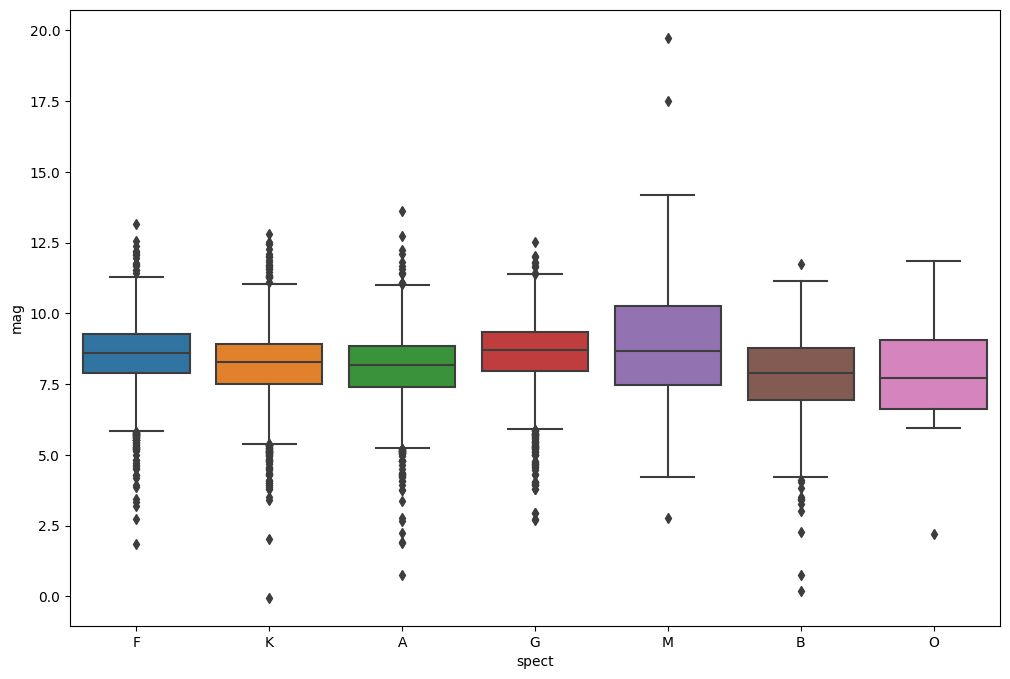

In [30]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='spect', y='mag', data=df_to_visualize)
plt.show()

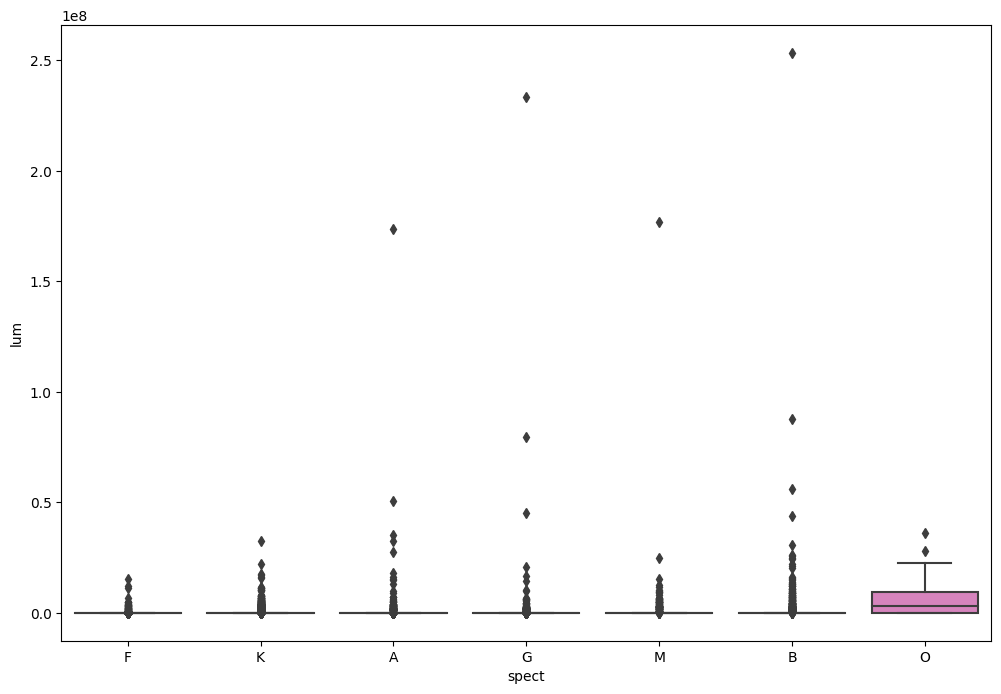

In [31]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='spect', y='lum', data=df_to_visualize)
plt.show()

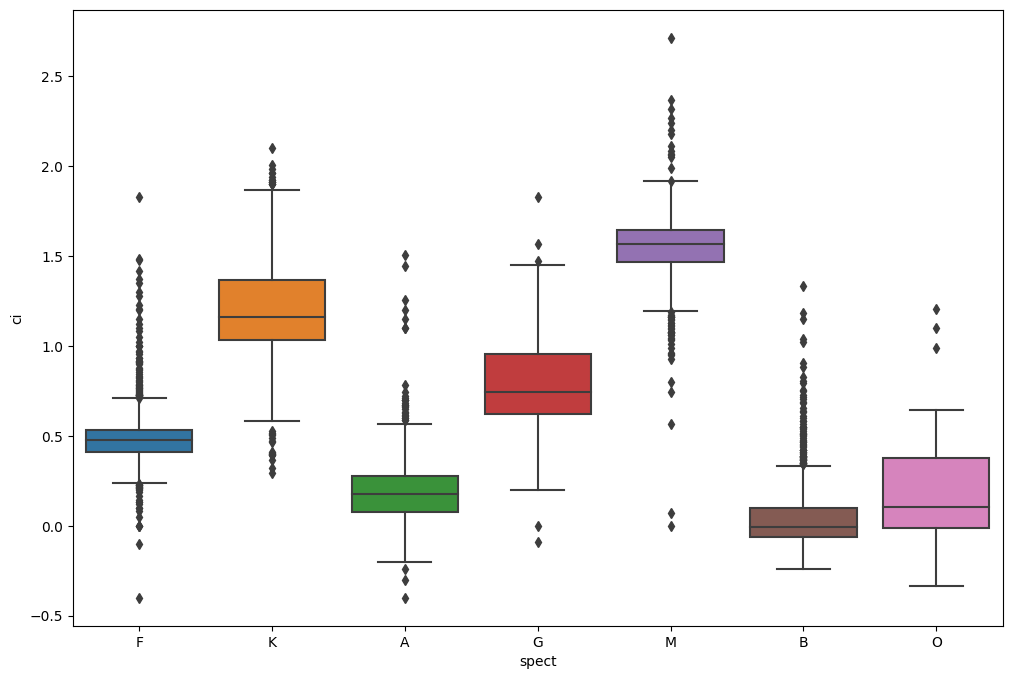

In [32]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='spect', y='ci', data=df_to_visualize)
plt.show()

In [21]:
y = HYG["spect"]
X = HYG.drop(columns = ["spect", "dist"])

# KNN

In [22]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
model = KNeighborsClassifier(n_neighbors = 5)
scores_knn = cross_val_score(model, X, y, scoring = 'accuracy', cv = kf)

In [23]:
scores_knn

array([0.41269084, 0.41440035, 0.41418347, 0.41331598, 0.41344611])

# SVC

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
clf = make_pipeline(StandardScaler(), SVC(gamma = 'auto'))
scores_svc = cross_val_score(clf, X, y, scoring = 'accuracy', cv = kf)

In [ ]:
scores_svc